### Code to plot a telemetry profile (Beta!)
#### 2021 01 20 CJH

In [110]:
import sys
import time
from networktables import NetworkTables
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [61]:
# ip = '172.22.11.2' # robot
# ip = 'roboRIO-2429-FRC.local'
ip = 'localhost'  # simulation
NetworkTables.initialize(server=ip)

False

In [62]:
def valueChanged(table, key, value, isNew):
    print("valueChanged: key: '%s'; value: %s; isNew: %s" % (key, value, isNew))
def connectionListener(connected, info):
    print(info, "; Connected=%s" % connected)

In [63]:
NetworkTables.addConnectionListener(connectionListener, immediateNotify=True)

ConnectionInfo(remote_id='Robot', remote_ip='localhost', remote_port=1735, last_update=358390.984, protocol_version=768) ; Connected=True


In [6]:
sd = NetworkTables.getTable("SmartDashboard")

In [31]:
example = sd.getString('Odometry',0)
print(f'Example: {example}\nx:{example[3:8]} y:{example[13:18]} rot:{example[25:31]} ')

Example: X: +2.15  Y: +5.91  Rot: +83.29
x:+2.15 y:+5.91 rot:+83.29 


In [ ]:
odometry_list = sd.getStringArray('Odometry_List',0)

In [90]:
x = [float(i[3:8]) for i in odometry_list]
y = [float(i[13:18]) for i in odometry_list]
rot = [float(i[25:31]) for i in odometry_list]
df = pd.DataFrame({'x':x, 'y':y, 'rotation':rot})

In [6]:
def get_data():
    # this was a lot simpler but stupid network tables can only take 256 values per array
        odometry_list = sd.getStringArray('Odometry_List',0)
        x = [float(i[3:8]) for i in odometry_list]
        y = [float(i[13:18]) for i in odometry_list]
        rot = [float(i[25:31]) for i in odometry_list]
        df = pd.DataFrame({'x':x, 'y':y, 'rotation':rot})
    return df

ConnectionInfo(remote_id='Robot', remote_ip='roboRIO-2429-FRC.local', remote_port=1735, last_update=0, protocol_version=768) ; Connected=True


In [102]:
df[(df.index) % 20 == 0]

,x,y,rotation
0,7.36,2.37,-103.20
20,10.80,0.30,-15.30
40,13.30,2.60,153.00
60,13.40,1.00,5.34
80,14.20,5.40,92.30
100,11.70,6.90,-177.00
120,6.17,7.35,-154.80
140,0.96,6.32,-126.10
160,3.59,4.65,-142.60
180,2.60,3.25,-15.76


In [177]:
def plot_df(df):
# multiple line plot
    save = False
    markersize = 3
    linewidth = 1.2
    label = "Mapping Odometry from Robot"
    ax = df.plot.scatter(x='x', y='y',c='rotation', colormap='viridis', figsize=(16,10))
    #plt.legend()
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title(label, fontsize=16)
    ax.set_ylabel('y position on field', fontsize = 16)
    ax.set_xlabel('x position on field', fontsize = 16)
    if save:
        plt.ioff()
        plt.savefig(fname)
        plt.close()
    plt.tight_layout()
    plt.show()


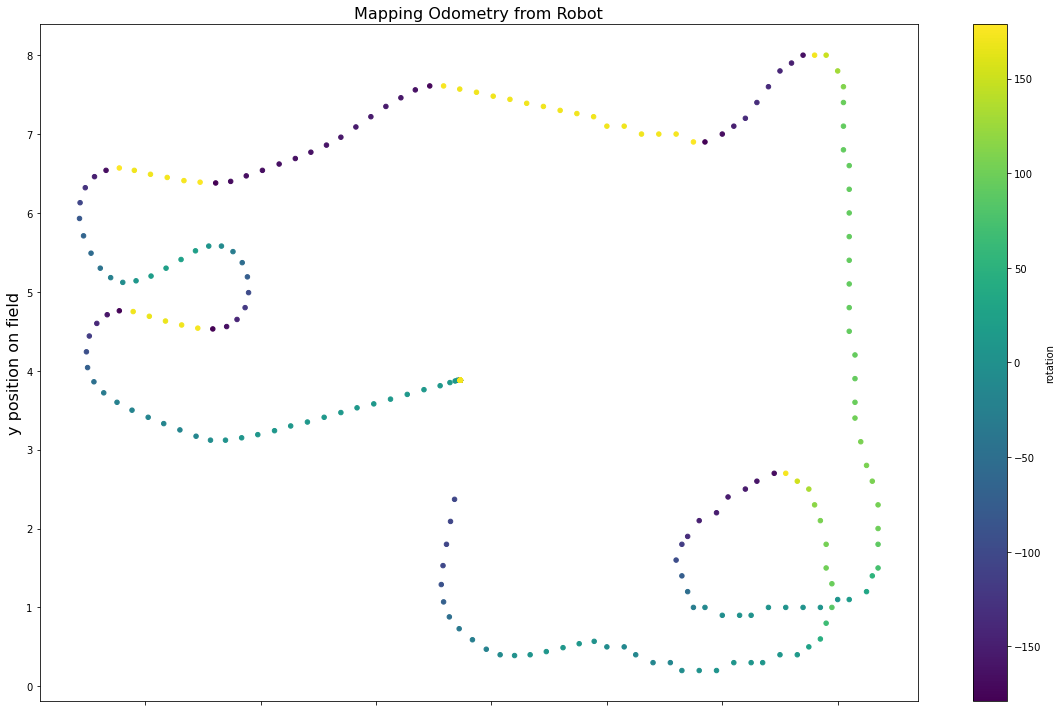

In [178]:
plot_df(df)

---
#### Pickle the data if desired (write python data to file for later use)

In [116]:
from datetime import datetime
time_stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
pickle_dir = r'.\pickle'
outfile = pickle_dir + '\\' + time_stamp +'.pkl'
with open(outfile, 'wb') as fp:
    pickle.dump(df, fp)

#### load data from pickle

In [118]:
# get a list of all the files 
import glob
pickle_dir = r'.\pickle'
files = glob.glob(pickle_dir+ '\*')
files

['.\\pickle\\20210120_144817.pkl', '.\\pickle\\20210120_144951.pkl']

In [119]:
infile = files[-1]
try:
    with open(infile, 'rb') as fp:
        df = pickle.load(fp)
except ValueError as e:
    print(f'Missing df in pickle {infile}, please create it and re-pickle')

In [121]:
df[(df.index) % 20 == 0]

,x,y,rotation
0,7.36,2.37,-103.20
20,10.80,0.30,-15.30
40,13.30,2.60,153.00
60,13.40,1.00,5.34
80,14.20,5.40,92.30
100,11.70,6.90,-177.00
120,6.17,7.35,-154.80
140,0.96,6.32,-126.10
160,3.59,4.65,-142.60
180,2.60,3.25,-15.76
